In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
# from xgboost.sklearn import XGBRegressor
import xgboost

# import sys
# install package from jupyter notebook
# !{sys.executable} -m pip install xgboost

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]

## 1. Request data from API and save them into pd dataframe

In [2]:
API_URL = 'https://api.iextrading.com/1.0'
res = requests.get(f'{API_URL}/stock/DFS/chart/5y')

In [3]:
data = res.json()
df = pd.DataFrame(data)
print("From the info() command we can see that date is treated as a string here, \n\
Let's change it to date time format.")
print(df.info())
df.head()

From the info() command we can see that date is treated as a string here, 
Let's change it to date time format.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 12 columns):
change              1258 non-null float64
changeOverTime      1258 non-null float64
changePercent       1258 non-null float64
close               1258 non-null float64
date                1258 non-null object
high                1258 non-null float64
label               1258 non-null object
low                 1258 non-null float64
open                1258 non-null float64
unadjustedVolume    1258 non-null int64
volume              1258 non-null int64
vwap                1258 non-null float64
dtypes: float64(8), int64(2), object(2)
memory usage: 118.0+ KB
None


,change,changeOverTime,changePercent,close,date,high,label,low,open,unadjustedVolume,volume,vwap
0,0.998322,0.000000,2.062,49.4169,2013-12-18,49.4895,"Dec 18, 13",47.7497,48.6001,3576474,3576474,48.6023
1,-0.499161,-0.010100,-1.010,48.9178,2013-12-19,49.4168,"Dec 19, 13",48.7362,49.2626,2044516,2044516,48.9653
2,0.090754,-0.008264,0.186,49.0085,2013-12-20,49.1083,"Dec 20, 13",48.7181,48.9541,4133222,4133222,48.9973
3,0.018152,-0.007896,0.037,49.0267,2013-12-23,49.3080,"Dec 23, 13",48.8088,49.3080,1648537,1648537,49.0302
4,0.308573,-0.001653,0.629,49.3352,2013-12-24,49.4260,"Dec 24, 13",49.0176,49.0448,1152856,1152856,49.1716


In [4]:
# change it to date time
df["date_time"] = pd.to_datetime(df.date)
df["month"] = df["date_time"].apply(lambda x: x.month)
df["day"] = df["date_time"].apply(lambda x: x.day)
df["weekday"] = df["date_time"].apply(lambda x: x.dayofweek)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 16 columns):
change              1258 non-null float64
changeOverTime      1258 non-null float64
changePercent       1258 non-null float64
close               1258 non-null float64
date                1258 non-null object
high                1258 non-null float64
label               1258 non-null object
low                 1258 non-null float64
open                1258 non-null float64
unadjustedVolume    1258 non-null int64
volume              1258 non-null int64
vwap                1258 non-null float64
date_time           1258 non-null datetime64[ns]
month               1258 non-null int64
day                 1258 non-null int64
weekday             1258 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(5), object(2)
memory usage: 157.3+ KB
None


,change,changeOverTime,changePercent,close,date,high,label,low,open,unadjustedVolume,volume,vwap,date_time,month,day,weekday
0,0.998322,0.000000,2.062,49.4169,2013-12-18,49.4895,"Dec 18, 13",47.7497,48.6001,3576474,3576474,48.6023,2013-12-18,12,18,2
1,-0.499161,-0.010100,-1.010,48.9178,2013-12-19,49.4168,"Dec 19, 13",48.7362,49.2626,2044516,2044516,48.9653,2013-12-19,12,19,3
2,0.090754,-0.008264,0.186,49.0085,2013-12-20,49.1083,"Dec 20, 13",48.7181,48.9541,4133222,4133222,48.9973,2013-12-20,12,20,4
3,0.018152,-0.007896,0.037,49.0267,2013-12-23,49.3080,"Dec 23, 13",48.8088,49.3080,1648537,1648537,49.0302,2013-12-23,12,23,0
4,0.308573,-0.001653,0.629,49.3352,2013-12-24,49.4260,"Dec 24, 13",49.0176,49.0448,1152856,1152856,49.1716,2013-12-24,12,24,1


In [5]:
df.describe()

,change,changeOverTime,changePercent,close,high,low,open,unadjustedVolume,volume,vwap,month,day,weekday
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1.258000e+03,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.009127,0.204311,0.026358,59.513325,60.013253,59.009550,59.523295,2.805836e+06,2.805836e+06,59.517483,6.542925,15.761526,2.021463
std,0.820656,0.182155,1.372090,9.001524,9.112342,8.927735,9.035912,1.352222e+06,1.352222e+06,9.024888,3.422768,8.751518,1.400199
min,-5.766800,-0.172384,-7.984000,40.898200,41.739800,40.529400,41.512900,5.825500e+05,5.825500e+05,41.006200,1.000000,1.000000,0.000000
25%,-0.414056,0.070975,-0.708750,52.924275,53.397100,52.557900,52.911200,1.952859e+06,1.952859e+06,52.953925,4.000000,8.000000,1.000000
50%,0.037223,0.157241,0.056000,57.187250,57.588300,56.814950,57.118350,2.498208e+06,2.498208e+06,57.253000,7.000000,16.000000,2.000000
75%,0.478930,0.346782,0.813500,66.553800,67.441625,66.072375,66.765850,3.247040e+06,3.247040e+06,66.520650,10.000000,23.000000,3.000000
max,4.056700,0.613319,8.164000,79.725200,80.333100,79.176100,79.852700,1.960215e+07,1.960215e+07,79.927500,12.000000,31.000000,4.000000


Let's take a peek of the stock price of DFS among the past 5 years.


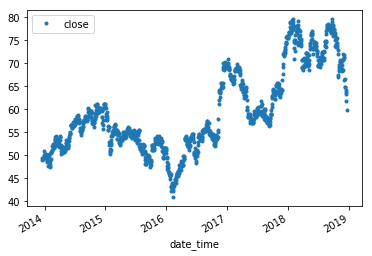

In [6]:
print("Let's take a peek of the stock price of DFS among the past 5 years.")
df.plot(x='date_time', y='close', style='.')

In [7]:
# we set the changePercent to be the target for prediction
y = df['changePercent']
y.head()

0    2.062
1   -1.010
2    0.186
3    0.037
4    0.629
Name: changePercent, dtype: float64

In [8]:
# we remove our y label and any non-numeric value from our X dataframe
X = df.drop(['changePercent', 'label','date','date_time'], 1)
X.head()

# notice that we may need to remove some of the open, close, high ,and low, or move them around
# as we shouldn't know those data when doing real-time prediction

,change,changeOverTime,close,high,low,open,unadjustedVolume,volume,vwap,month,day,weekday
0,0.998322,0.000000,49.4169,49.4895,47.7497,48.6001,3576474,3576474,48.6023,12,18,2
1,-0.499161,-0.010100,48.9178,49.4168,48.7362,49.2626,2044516,2044516,48.9653,12,19,3
2,0.090754,-0.008264,49.0085,49.1083,48.7181,48.9541,4133222,4133222,48.9973,12,20,4
3,0.018152,-0.007896,49.0267,49.3080,48.8088,49.3080,1648537,1648537,49.0302,12,23,0
4,0.308573,-0.001653,49.3352,49.4260,49.0176,49.0448,1152856,1152856,49.1716,12,24,1


In [9]:
# Now we split data into training and testing. 
# We use random_state to test whether normalization will be a good thing for this later.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.head()

,change,changeOverTime,close,high,low,open,unadjustedVolume,volume,vwap,month,day,weekday
952,0.117033,0.272581,62.8870,63.1309,62.3701,62.9553,2494510,2494510,62.7489,9,29,4
215,-0.091862,0.156960,57.1734,57.3387,56.8886,57.2285,2504947,2504947,57.1607,10,27,0
451,2.225800,0.032341,51.0151,51.2957,49.5281,49.5655,4898328,4898328,50.8672,10,5,0
27,-1.188900,-0.008631,48.9904,49.9887,48.8088,49.6892,3837339,3837339,49.1945,1,29,2
1212,-1.332300,0.492526,73.7560,75.5457,73.5174,74.8199,2273473,2273473,74.4128,10,11,3


In [10]:
# xgboost
xgb_model = xgboost.XGBRegressor(
    colsample_bytree=0.4,
    gamma=0,                 
    learning_rate=0.02,
    max_depth=3,
    n_estimators=10000,                                                                    
    seed=42)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [11]:
print(xgb_model.score(X_train, y_train))
print("Testing this model on test dataset and get score = ", mean_squared_error(xgb_model.predict(X_test), y_test))

0.9999968961415671
Testing this model on test dataset and get score =  0.0444710211681783


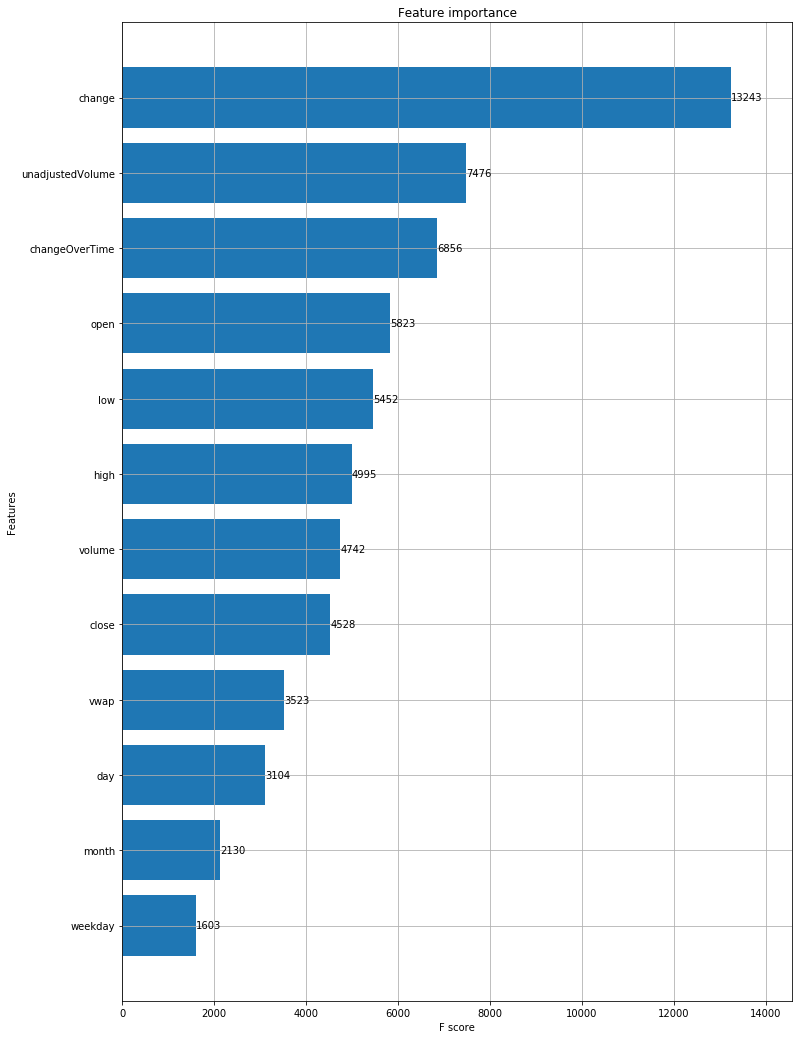

In [12]:
fig, ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(xgb_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [13]:
print("As we can see above, 'change' and 'changeOverTime' contributed a lot \n\
to our model. However, we shouldn't have access to those data when we are predicting \n\
at real time. Now let's drop it and see how it changes.")

X = df.drop(['changePercent','change','changeOverTime','close' ,'label','date','date_time'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.head()

As we can see above, 'change' and 'changeOverTime' contributed a lot 
to our model. However, we shouldn't have access to those data when we are predicting 
at real time. Now let's drop it and see how it changes.


,high,low,open,unadjustedVolume,volume,vwap,month,day,weekday
952,63.1309,62.3701,62.9553,2494510,2494510,62.7489,9,29,4
215,57.3387,56.8886,57.2285,2504947,2504947,57.1607,10,27,0
451,51.2957,49.5281,49.5655,4898328,4898328,50.8672,10,5,0
27,49.9887,48.8088,49.6892,3837339,3837339,49.1945,1,29,2
1212,75.5457,73.5174,74.8199,2273473,2273473,74.4128,10,11,3


In [14]:
xgb_model2 = xgboost.XGBRegressor(
    colsample_bytree=0.4,
    gamma=0,                 
    learning_rate=0.02,
    max_depth=3,
    n_estimators=10000,                                                                    
    seed=42)

xgb_model2.fit(X_train, y_train)
print("Training score = ",xgb_model2.score(X_train, y_train))
print("Testing this model on test dataset and get score = ", mean_squared_error(xgb_model2.predict(X_test),y_test))

Training score =  0.9963110876207392
Testing this model on test dataset and get score =  1.498693905127205


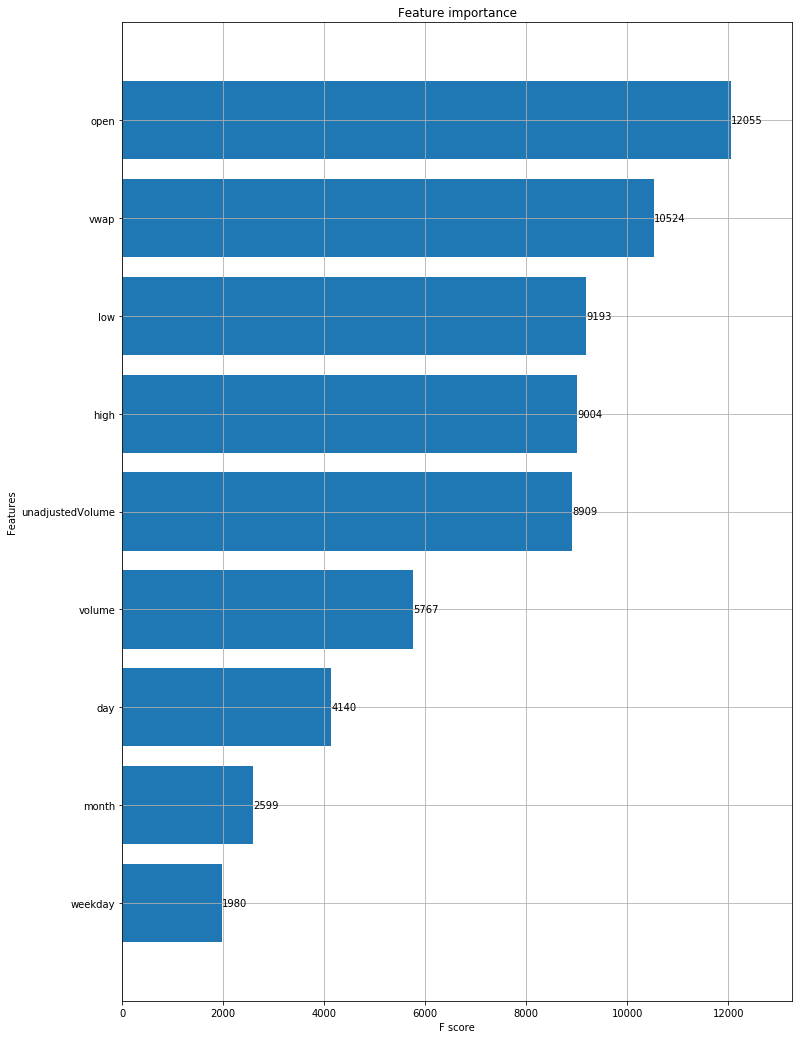

In [15]:
fig, ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(xgb_model2, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [16]:
# now let's see how does normalization does

X_column_names = X_train.columns
min_max_scaler = preprocessing.MinMaxScaler()
X_train2 = pd.DataFrame(min_max_scaler.fit_transform(X_train))
X_test2 = pd.DataFrame(min_max_scaler.fit_transform(X_test))
y_train2 = (y_train - y_train.mean())/y_train.std()
y_test2 = (y_test - y_test.mean())/y_test.std()

X_train2.columns = X_column_names
X_test2.columns = X_column_names

print("It do feels wired to normalize dummy variables like day and weekday...")
X_train2.head()
# normalized_df = pd.DataFrame(X_scaled)

It do feels wired to normalize dummy variables like day and weekday...


,high,low,open,unadjustedVolume,volume,vwap,month,day,weekday
0,0.554270,0.565138,0.556649,0.153270,0.153270,0.558632,0.727273,0.933333,1.00
1,0.404187,0.423301,0.406390,0.154146,0.154146,0.415056,0.818182,0.866667,0.00
2,0.247605,0.232845,0.205329,0.354981,0.354981,0.253357,0.818182,0.133333,0.00
3,0.213739,0.214233,0.208575,0.265950,0.265950,0.210381,0.000000,0.933333,0.50
4,0.875953,0.853579,0.867950,0.134723,0.134723,0.858312,0.818182,0.333333,0.75


In [17]:
xgb_model3 = xgboost.XGBRegressor(
    colsample_bytree=0.4,
    gamma=0,                 
    learning_rate=0.02,
    max_depth=3,
    n_estimators=10000,                                                                    
    seed=42)

xgb_model3.fit(X_train2, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [18]:
print("Training score = ",xgb_model3.score(X_train2, y_train2))
print("Testing this model on test dataset and get score = ", mean_squared_error(xgb_model3.predict(X_test2),y_test2))

Training score =  0.879115630381135
Testing this model on test dataset and get score =  1.1018076387399902


As we can see, despite the reduce on training score, normalization helps us 
to get a better score on testing dataset, which is all we care about.


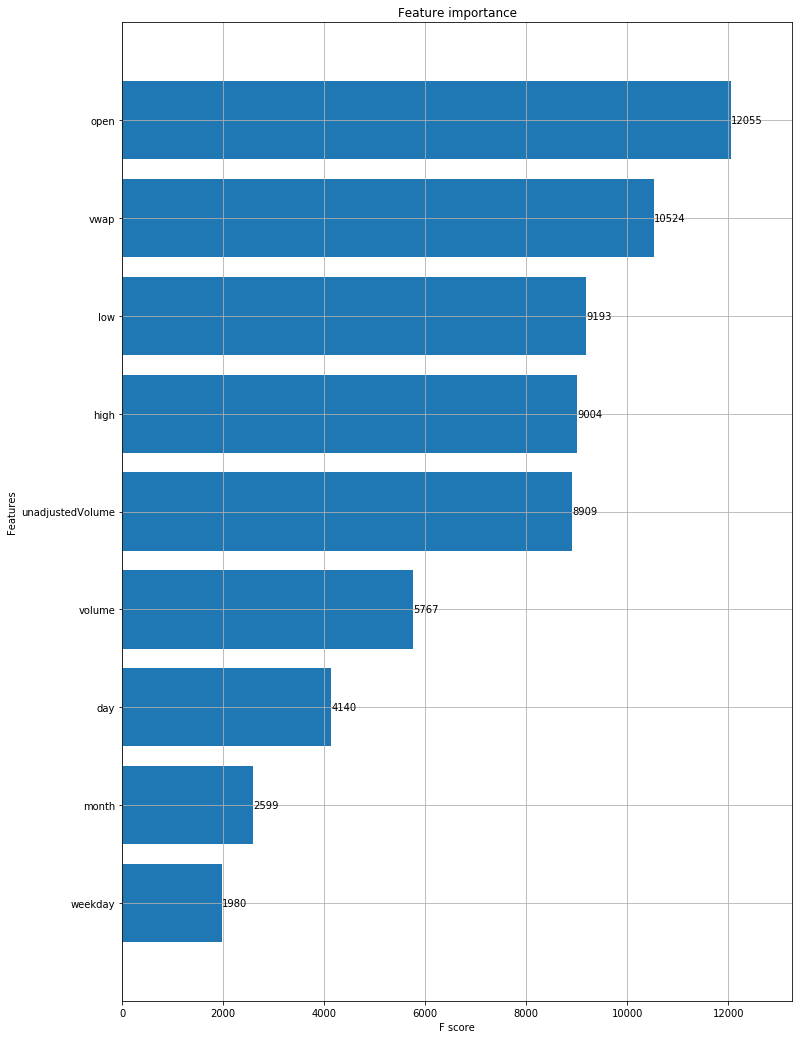

In [19]:
print("As we can see, despite the reduce on training score, normalization helps us \n\
to get a better score on testing dataset, which is all we care about.")
fig, ax = plt.subplots(figsize=(12,18))
xgboost.plot_importance(xgb_model2, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Conclusions
1. As we can see open price and the vwap (Volume Weighted Average Price) are the two most important features when predicting price of DFS stocks.  
2. The time of the year, aka. day, month, weekday are relatively irrelevant for stock's price. (which implies, the time-dependency of stock rely more on timely news than any perticular time of the year.)    
3. Normalization generally helps.  